<a href="https://colab.research.google.com/github/khoji-code/Data-Science-AI-for-Business-Portfolio/blob/main/Deep_Embedded_Clustering_for_RFM_Based_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Embedded Clustering for RFM-Based Customer Segmentation

### **Project Overview**

* **Goal:** To segment customers from a UK-based online retail dataset into distinct groups using advanced machine learning techniques.
* **Dataset:** Utilizes the "Online Retail II" dataset from the UCI Machine Learning Repository, containing transactional data for an online retail store.
* **Methodology:** The project starts with comprehensive data cleaning and feature engineering to create RFM (Recency, Frequency, Monetary) scores for each customer. A deep autoencoder is then built and trained using TensorFlow to learn a compressed representation of the RFM data. Finally, a Deep Embedded Clustering (DEC) model is used to fine-tune the clusters and assign customers to one of five segments.
* **Key Insights:** The analysis successfully identifies distinct customer segments, such as "High-Value Champions," "At-Risk Customers," "New Customers," and "Lost Customers," providing a nuanced understanding of the customer base.

***

### **Purpose**

* **Advanced Customer Segmentation:** To move beyond traditional clustering methods and leverage deep learning to uncover more meaningful and actionable customer segments.
* **Personalized Marketing:** To enable the business to create highly targeted marketing campaigns tailored to the specific behaviors and value of each customer segment, thereby increasing engagement and ROI.
* **Strategic Business Decisions:** To provide data-driven insights that can inform strategic decisions related to customer retention, acquisition, and product offerings. For instance, "At-Risk Customers" can be targeted with win-back campaigns, while "High-Value Champions" can be enrolled in loyalty programs.

### Dataset:
https://archive.ics.uci.edu/dataset/502/online+retail+ii

## Import Libraries

In [ ]:
# Installing Libs
# !pip install scikit-learn==1.2.2
# !pip install tensorflow
# !pip install numpy==1.26.4

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import gc # Garbage collection to manage memory

# Import machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# Import deep learning libraries from TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Set some display options for pandas and matplotlib for better visualization
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
print("TensorFlow Version:", tf.__version__)
print("Libraries imported successfully.")


TensorFlow Version: 2.19.0
Libraries imported successfully.


## Load Dataset

In [ ]:
try:
    # The dataset has mixed types, so we specify 'unicode_escape' encoding.
    df_raw = pd.read_csv('/content/drive/MyDrive/uk-retail/online_retail_II.csv', encoding='unicode_escape')
    print("Dataset loaded successfully. Shape:", df_raw.shape)
except FileNotFoundError:
    print("Error: 'online_retail_II.csv' not found. Please ensure the file is uploaded.")
    exit()

Dataset loaded successfully. Shape: (1067371, 8)


### Data Cleaning

In [ ]:
# Drop missing Customer ID
df_raw.dropna(subset=['Customer ID'], inplace=True)

# Convert Customer ID to integer.
df_raw['Customer ID'] = df_raw['Customer ID'].astype(int)
# Remove returns/cancellations (Invoices starting with 'C').
df_raw = df_raw[~df_raw['Invoice'].str.startswith('C', na=False)]
# Remove rows with negative quantity.
df_raw = df_raw[df_raw['Quantity'] > 0]

# Convert InvoiceDate to datetime objects.
df_raw['InvoiceDate'] = pd.to_datetime(df_raw['InvoiceDate'])

# Calculate total price for each transaction.
df_raw['TotalPrice'] = df_raw['Quantity'] * df_raw['Price']

print("Shape after cleaning:", df_raw.shape)
print("Data types:\n", df_raw.dtypes)

Shape after cleaning: (805620, 9)
Data types:
 Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID             int64
Country                object
TotalPrice            float64
dtype: object


## RFM Feature Engineering

We will now aggregate the transactional data to create customer-level features
based on the Recency, Frequency, and Monetary (RFM) model.


In [ ]:
# Set a snapshot date for calculating recency. This is typically the day after the last transaction.
snapshot_date = df_raw['InvoiceDate'].max() + dt.timedelta(days=1)

# Aggregate data on a customer level.
rfm = df_raw.groupby('Customer ID').agg({
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days, # Recency: days since last purchase
    'Invoice': 'nunique',                                         # Frequency: number of unique invoices
    'TotalPrice': 'sum'                                           # Monetary: total spend
})

# Rename the columns for clarity.
rfm.rename(columns={'InvoiceDate': 'Recency',
                    'Invoice': 'Frequency',
                    'TotalPrice': 'MonetaryValue'}, inplace=True)

print("RFM features created. Shape:", rfm.shape)
print("First 5 rows of RFM data:")
print(rfm.head())

RFM features created. Shape: (5881, 3)
First 5 rows of RFM data:
             Recency  Frequency  MonetaryValue
Customer ID                                   
12346            326         12       77556.46
12347              2          8        5633.32
12348             75          5        2019.40
12349             19          4        4428.69
12350            310          1         334.40


### Handle Skewness and Scale Data

In [ ]:
# RFM features are often highly skewed. We apply a log transformation to normalize them.
# add 1 to avoid log(0) errors.
rfm_log = np.log1p(rfm)

# Scale the features to have a mean of 0 and standard deviation of 1.
# This is crucial for both K-Means and the deep learning model.
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)


## Build and Train the Deep Autoencoder

In [ ]:
# Define the dimensions of our network.
input_dim = rfm_scaled.shape[1] # Should be 3 (R, F, M)
encoding_dim = 10 # The size of the compressed representation.

# Define the Encoder
input_layer = Input(shape=(input_dim,), name='input')
encoder = Dense(50, activation='relu', name='encoder_1')(input_layer)
encoder = Dense(50, activation='relu', name='encoder_2')(encoder)
encoder = Dense(encoding_dim, activation='relu', name='embedding')(encoder) # The final embedding layer

# Define the Decoder
# This part tries to reconstruct the original input from the compressed embedding.
decoder = Dense(50, activation='relu', name='decoder_1')(encoder)
decoder = Dense(50, activation='relu', name='decoder_2')(decoder)
decoder = Dense(input_dim, name='output')(decoder) # Output has the same dimension as the input

# Compile the Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=decoder, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='mse') # We use Mean Squared Error to measure reconstruction loss.
autoencoder.summary()

# Train the Autoencoder
autoencoder.fit(rfm_scaled, rfm_scaled,
                batch_size=256,
                epochs=100,
                shuffle=True,
                validation_split=0.1,
                verbose=1)

encoder_model = Model(inputs=input_layer, outputs=encoder, name='encoder')

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 50)             │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 50)             │           550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,513 (25.44 KB)

 Trainable params: 6,513 (25.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.9377 - val_loss: 0.6753
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4716 - val_loss: 0.1154
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0704 - val_loss: 0.0410
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0343 - val_loss: 0.0205
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0121 - val_loss: 0.0053
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.4224e-04 - val_loss: 0.0014
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss

## Deep Embedded Clustering (DEC)

In [ ]:
# get the embeddings from our trained encoder
encoded_data = encoder_model.predict(rfm_scaled)

# K-Means on these embeddings to find initial cluster centers
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=42)
y_pred_kmeans = kmeans.fit_predict(encoded_data)
cluster_centers = kmeans.cluster_centers_

# Define the Custom Clustering Layer
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.initial_weights = weights

    def build(self, input_shape):
        # This creates a trainable weight matrix for the cluster centers.
        self.clusters = self.add_weight(shape=(self.n_clusters, input_shape[1]),
                                        initializer='glorot_uniform',
                                        name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
        super().build(input_shape)

    def call(self, inputs):
        # This calculates the similarity between each input embedding and the cluster centers
        # using the Student's t-distribution.
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / 1.0))
        q **= (1.0 + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


### Build the Full DEC Model

In [ ]:
clustering_layer = ClusteringLayer(n_clusters, weights=[cluster_centers], name='clustering')(encoder_model.output)
dec_model = Model(inputs=encoder_model.input, outputs=clustering_layer, name='DEC')
dec_model.compile(optimizer=Adam(0.01), loss='kld') # Kullback-Leibler Divergence as the loss function.


### Fine-tune the DEC Model

In [ ]:
# calculate an auxiliary target distribution 'p' to help guide the training.
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

q = dec_model.predict(rfm_scaled)
p = target_distribution(q)

# Fine-tune for 50 epochs.
dec_model.fit(rfm_scaled, p, epochs=50, batch_size=256, verbose=1)

print("\nDEC model fine-tuning complete.")
# Get the final cluster assignments.
q_final = dec_model.predict(rfm_scaled)
y_pred_dec = q_final.argmax(1)

# Add the cluster labels to our original RFM dataframe.
rfm['KMeans_Cluster'] = y_pred_kmeans
rfm['DEC_Cluster'] = y_pred_dec

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1264
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0591
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0461
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0370
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0324
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0278
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0258
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0248
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0232
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0198
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0197
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0178
Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0178
Epoch 15/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

## Evaluation and Visualization of Segments

### Silhouette Score

In [ ]:
sil_kmeans = silhouette_score(encoded_data, y_pred_kmeans)
sil_dec = silhouette_score(encoded_data, y_pred_dec)
print(f"Silhouette Score (K-Means on embeddings): {sil_kmeans:.3f}")
print(f"Silhouette Score (DEC): {sil_dec:.3f}")
print("DEC typically improves cluster separation, leading to a higher score.")


Silhouette Score (K-Means on embeddings): 0.340
Silhouette Score (DEC): 0.335
DEC typically improves cluster separation, leading to a higher score.


### t-SNE Visualization

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5881 samples in 0.029s...
[t-SNE] Computed neighbors for 5881 samples in 0.786s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5881
[t-SNE] Computed conditional probabilities for sample 2000 / 5881
[t-SNE] Computed conditional probabilities for sample 3000 / 5881
[t-SNE] Computed conditional probabilities for sample 4000 / 5881
[t-SNE] Computed conditional probabilities for sample 5000 / 5881
[t-SNE] Computed conditional probabilities for sample 5881 / 5881
[t-SNE] Mean sigma: 0.140416
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.353653
[t-SNE] KL divergence after 300 iterations: 1.816713


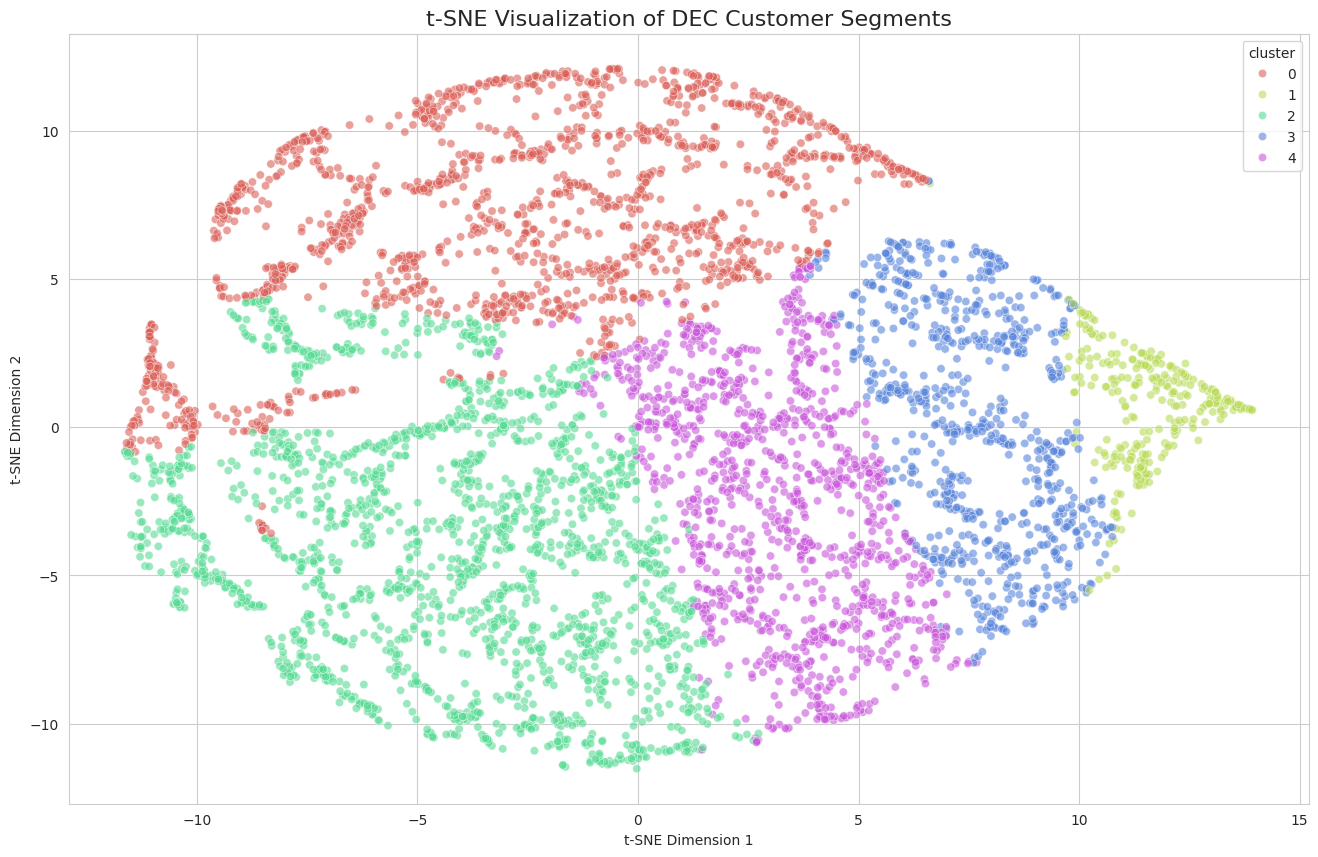

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(encoded_data)

# Create a DataFrame for plotting.
df_tsne = pd.DataFrame()
df_tsne['tsne-2d-one'] = tsne_results[:,0]
df_tsne['tsne-2d-two'] = tsne_results[:,1]
df_tsne['cluster'] = y_pred_dec

# Plot the results.
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="cluster",
    palette=sns.color_palette("hls", n_clusters),
    data=df_tsne,
    legend="full",
    alpha=0.6
)
plt.title('t-SNE Visualization of DEC Customer Segments', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

### Segment Profiling

In [ ]:
# Let's analyze the characteristics of each customer segment.
segment_profile = rfm.groupby('DEC_Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(2)

print("\n--- Customer Segment Profiles ---")
print(segment_profile)



--- Customer Segment Profiles ---
            Recency Frequency MonetaryValue      
               mean      mean          mean count
DEC_Cluster                                      
0            369.02      1.18        229.06  1632
1             13.36     40.44      28480.80   294
2            245.43      3.42       1131.08  2020
3             23.44     10.89       4854.38   809
4             56.73      6.62       2472.71  1126


## Business Action Plan:
By analyzing the segment profiles, we can create targeted marketing strategies:
- High-Value Champions: A group with low Recency, high Frequency, and high Monetary value. These are our best customers. We should target them with loyalty programs and exclusive offers.
- At-Risk Customers: A group with high Recency but decent Frequency/Monetary value. They haven't purchased in a while. We should target them with win-back campaigns.
- New Customers: A group with low Recency, low Frequency, and low Monetary value. We should focus on onboarding them and encouraging their next purchase.
- Lost Customers: A group with very high Recency and low Frequency/Monetary value. It might not be cost-effective to target them.
This deep clustering approach provides a much more nuanced view of the customer base than traditional methods.